In [1]:
import pandas as pd
import os
import glob
import time

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO
import panel as pn
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.io import export_svg, output_notebook, install_notebook_hook, notebook
import numpy as np
import re
import seaborn as sb

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
def timems():
    return round(time.time() * 1000)

In [3]:
def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)

def merge_windows(wins):
    a = [wins[0]]
    for i in range(len(wins)-1):
        prev = a[len(a)-1]
        next = wins[i+1]
        if prev[1] + 1 >= next[0]:
            a[len(a)-1] = (a[len(a)-1][0], next[1])
        else:
            a.append(next)
    return a

def read_identity(path, ref):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    df.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    idx1 = df["seq1"].str.contains(ref)
    idx2 = df["seq2"].str.contains(ref)
    df = df[idx1 | idx2]
    idx = (df["seq2"].str.contains(ref))
    # put all references to the seq2 column
    df.loc[idx, ["seq1", "seq2"]] = df.loc[idx, ["seq2", "seq1"]].values
    df["seq2"] = df["seq2"].map(lambda x: x.split("|")[1])
    df = df.drop(columns=["seq1"]).set_index("seq2")
    return dict(zip(df.index, df.identity))

def read_stride(path):
    data = []
    with open(path, "r") as f:
        for line in f.readlines():
            if line[:3] == "ASG":
                data.append(re.split("\s+", line)[6])
    return data

def read_safe_sequences(safety_path, stride_path):
    safe_sequences = []
    raw = ""
    with open(safety_path, "r") as f:
        raw = ("\n" + f.read()).split("\n>")[1:]
    ref_accession = raw[0].split("\n")[0].split(" ")[0].strip().split("|")[1]
    ref = raw[0].split("\n")[1].strip()

    for data in raw[1:]:
        splitted = data.split("\n")
        accession = splitted[0].split(" ")[0].split("|")[1]
        seq = splitted[1].strip()
        rwindows = []
        swindows = []
        for line in splitted[3:]:
            ends = line.split()
            if len(ends) != 4:
                continue
            rwindows.append((int(ends[0]), int(ends[1])))
            swindows.append((int(ends[2]), int(ends[3])))
        rwindows = merge_windows(rwindows)
        swindows = merge_windows(swindows)
        safe_sequences.append(SafeSequence(accession, seq, rwindows, swindows, stride_path))
        
    return (ref, ref_accession, safe_sequences)

In [4]:
def get_colors(seqs, longest):
    """make colors for bases in sequence"""
    colors = []
    for ss in seqs:
        colors += ss.get_stride_colors(longest)
        colors += ss.get_safety_window_colors(longest)
    colors += ["white" for i in range(longest)]
    return colors

def get_columns(ref, seqs, longest):
    text = ""
    for ss in seqs:
        s = ss.sequence + (" " * (longest - len(ss.sequence)))
        text += ss.get_strides() + (" " * (longest - len(ss.sequence)))
        text += s
    text += ref + (" " * (longest - len(ref)))
    return list(text)

In [5]:
clrs = ["steelblue"]
flex = ["Coil", "Strand", "Turn"]
acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V", "U", "O"]

class SafeSequence():
    def __init__(self, accession, sequence, ref_windows, seq_windows, stride_path):
        self.accession = accession
        self.sequence = sequence
        self.identity = 0.0
        self.ref_windows = ref_windows
        self.seq_windows = seq_windows
        self.safe_bases = 0
        self.stable_bases = 0
        self.strides = self.read_strides(stride_path)
        self.TP, self.TN, self.FP, self.FN = 0,0,0,0
        self.calculate_hits()
        if self.TP + self.FP == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.precision = 0
        else: 
            self.precision = self.TP / max(self.TP + self.FP, 1)
        if self.TP + self.FN == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.recall = 0
        else:
            self.recall = self.TP / max(self.TP + self.FN, 1)

        # base distribution in the sequence
        # self.safe_distribution = {}
        # self.non_safe_distribution = {}
        # self.distribution = {}
        # for acid in acids:
        #     self.distribution[acid] = 0
        #     self.safe_distribution[acid] = 0
        #     self.non_safe_distribution[acid] = 0
        # self.calculate_distributions()

    def calculate_hits(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            stable = self.is_stable(i)
            self.safe_bases += safe
            self.stable_bases += stable
            self.TP += (safe and stable)
            self.TN += (not safe and not stable)
            self.FP += (safe and not stable)
            self.FN += (not safe and stable)
        assert self.TP + self.TN + self.FP + self.FN == len(self.sequence), f"Hits do not match"

    def calculate_distributions(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            aa = self.sequence[i]
            self.distribution[aa] += 1
            self.safe_distribution[aa] += safe
            self.non_safe_distribution[aa] += not safe

    def is_safe(self, i):
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            if i >= start and i <= end:
                return True
        return False

    def is_stable(self, i):
        return self.strides[i] not in flex

    def get_safety_window_colors(self, longest):
        colors = ["white"] * longest
        clr = 0
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            for i in range(start, end):
                colors[i] = clrs[clr % len(clrs)]
            
            clr += 1
        return colors

    def get_stride_colors(self, longest):
        colors = []
        for stride in self.strides:
            if stride not in flex:
                colors.append("palegreen")
            else:
                colors.append("white")
        
        return colors + (["white"] * (longest - len(self.sequence)))

    def get_strides(self):
        return "".join([stride[0] for stride in self.strides])

    def read_strides(self, path):
        return read_stride(f"{path}/{self.accession}.out")

class Cluster():
    def __init__(self, safe_path, stride_path, id_path):
        self.ref_seq, self.ref_accession, self.sequences = read_safe_sequences(safe_path, stride_path)
        identity_df = read_identity(id_path, self.ref_accession)
        for ss in self.sequences:
            ss.identity = identity_df[ss.accession]
        del(identity_df)
        self.precision, self.recall = self.get_precision_recall()
        self.avg_safe_coverage = self.get_safe_coverage()
        self.avg_stable_coverage = self.get_stable_coverage()

    def get_precision_recall(self):
        tp, fp, tn, fn = 0,0,0,0
        for ss in self.sequences:
            tp += ss.TP
            fp += ss.FP
            tn += ss.TN
            fn += ss.FN
        return (tp/(tp+fp), tp/(tp+fn))

    def get_safe_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.safe_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage

    def get_stable_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.stable_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage

    def plot_windows(self):
        longest = len(self.ref_seq)
        for ss in self.sequences:
            longest = max(len(ss.sequence), longest)

        text = get_columns(self.ref_seq, self.sequences, longest)
        colors = get_colors(self.sequences, longest)
        cols = longest
        rows = len(self.sequences)*2+1
        x = np.arange(1, cols + 1)
        y = np.arange(0, rows, 1)
        xx, yy = np.meshgrid(x, y)
        gx = xx.ravel()
        gy = yy.flatten()
        recty = gy + 0.5
        d = dict(x=gx, y=gy, recty=recty, text=text, colors=colors)
        source = ColumnDataSource(d)
        plot_height = rows * 15
        plot_width = longest * 15
        x_range = Range1d(0, cols + 1, bounds='auto')

        rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors", line_color=None, fill_alpha=0.8)
        glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black", text_font_size="4pt")
        
        p = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=(0,rows),
                min_border=0, toolbar_location='below')
        p.add_glyph(source, rects)
        p.add_glyph(source, glyph)    
        p = gridplot([[p]])

        return p

In [6]:
def get_clusters(work_dir, alpha, delta):
    safety_files = sorted(glob.glob(os.path.join(work_dir, f"safety.a{alpha}.d{delta}", "*.out")))
    identity_files = sorted(glob.glob(os.path.join(work_dir, "id", "*.out")))
    stride_files = sorted(filter(os.path.isdir, glob.glob(os.path.join(work_dir, "stride", "*"))))
    
    assert len(safety_files) == len(stride_files) and len(identity_files) == len(safety_files), f"Not proper file count {len(safety_files)} {len(identity_files)} {len(stride_files)}"
    
    z = list(zip(safety_files, stride_files, identity_files))
    clusters = []
    for file in tqdm(z):
        clusters.append(Cluster(file[0], file[1], file[2]))

    return clusters

In [7]:
def to_df(clusters):
    safe_coverage = []
    stable_coverage = []
    precision = []
    recall = []
    identity = []
    refs = []
    ids = []
    for cluster in clusters:
        for ss in cluster.sequences:
            refs.append(cluster.ref_accession)
            ids.append(ss.accession)
            identity.append(ss.identity)
            recall.append(ss.recall)
            precision.append(ss.precision)
            safe_coverage.append(ss.safe_bases / len(ss.sequence))
            stable_coverage.append(ss.stable_bases / len(ss.sequence))
    return pd.DataFrame(
        data={"ref":refs, "id":ids, "identity":identity,
        "recall":recall, "precision":precision,
        "safe_coverage": safe_coverage, "stable_coverage": stable_coverage})  
 
def get_all_clusters(path, alphas, deltas):
    groups = {}
    for alpha in alphas:
        for delta in deltas:
            print(f"a{alpha}.d{delta}")
            df_path = os.path.join(path, "df", "a" + f"a{alpha}.d{delta}.csv")
            if os.path.isfile(df_path):
                groups[(alpha, delta)] = pd.read_csv(df_path, index_col=0)
            else:
                groups[(alpha, delta)] = to_df(get_clusters(path, alpha, delta))
                groups[(alpha, delta)].to_csv(df_path)
    return groups

In [8]:
alphas = [50, 75, 99]
deltas = [0,2,4,6,8,10,15]
groups = get_all_clusters("./../out/sprot_filtered.20.multi-step", alphas, deltas)

a50.d0
a50.d2
a50.d4
a50.d6
a50.d8
a50.d10
a50.d15
a75.d0
a75.d2
a75.d4
a75.d6
a75.d8
a75.d10
a75.d15
a99.d0
a99.d2
a99.d4
a99.d6
a99.d8
a99.d10
a99.d15


In [9]:
def filter(groups, alphas, deltas):
    for a in alphas:
        for d in deltas:
            groups[(a, d)] = groups[(a, d)][groups[(a,d)].stable_coverage > 0]
            groups[(a, d)] = groups[(a, d)][groups[(a,d)].precision + groups[(a,d)].precision > 0]
    return groups

def plot_precision_recall(groups, alphas, deltas, id_range=None):
    fig, axes = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(5*len(alphas), 5*len(deltas)))
    for j, d in enumerate(deltas):
        for i, a in enumerate(alphas):
            if id_range != None:
                df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
            else:
                df = groups[(a, d)]
            axes[j][i].set_xlim(0, 1)
            axes[j][i].set_ylim(0, 1)
            axes[j][i].hist2d(df["precision"].values, df["recall"].values, bins=(50,50), cmap=plt.cm.jet, range=np.array([(0,1),(0,1)]))
            axes[j][i].set_title(f"a{a}.d{d}")
            axes[j][i].set_xlabel("precision")
            axes[j][i].set_ylabel("recall")

    plt.show()

def plot_f1(groups, alphas, deltas, id_range=None):
    fig, axes = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(5*len(alphas), 5*len(deltas)))
    for j, d in enumerate(deltas):
        for i, a in enumerate(alphas):
            if id_range != None:
                df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
            else:
                df = groups[(a, d)]
            f1 = (2 * df["precision"] * df["recall"])/(df["precision"] + df["recall"])
            axes[j][i].hist2d(f1.values, df["safe_coverage"].values, bins=(50,50), cmap=plt.cm.jet, range=np.array([(0,1),(0,1)]))
            axes[j][i].set_title(f"a{a}.d{d}")
            axes[j][i].set_xlabel("F1 Score")
            axes[j][i].set_ylabel("Safe Coverage")
    plt.show()

def plot_recall_safe_coverage(groups, alphas, deltas, id_range=None):
    fig, axes = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(5*len(alphas), 5*len(deltas)))
    for j, d in enumerate(deltas):
        for i, a in enumerate(alphas):
            if id_range != None:
                df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
            else:
                df = groups[(a, d)]
            axes[j][i].hist2d(df["recall"].values, df["safe_coverage"].values, bins=(50,50), cmap=plt.cm.jet, range=np.array([(0,1),(0,1)]))
            axes[j][i].set_title(f"a{a}.d{d}")
            axes[j][i].set_xlabel("Recall")
            axes[j][i].set_ylabel("Safe Coverage")
    plt.show()

def boxplot(groups, alphas, deltas, features, id_range=None):
    fig, ax = plt.subplots(nrows=len(features), figsize=(5*3, 6*len(features)))
    for i, f in enumerate(features):
        vals = []
        labels = []
        for a in alphas:
            for d in deltas:
                if id_range != None:
                    df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
                else:
                    df = groups[(a, d)]
                vals.append(df[f].values)
                labels.append(f"a{a}.d{d}")
        ax[i].boxplot(vals, showfliers=False)
        ax[i].set_xticklabels(labels, rotation=45)
        ax[i].set_title(f)
        ax[i].set_ylim([0,1])
    plt.show()

def combine(groups, alphas, deltas):
    res = pd.DataFrame()
    for a in alphas:
        for d in deltas:
            df = groups[(a,d)]
            df["alpha"] = a
            df["delta"] = d
            res = pd.concat([res, df])
    return res

In [10]:
groups = filter(groups, alphas, deltas)

Precision and recall heatmap for different alpha and delta parameters, all identities (%).

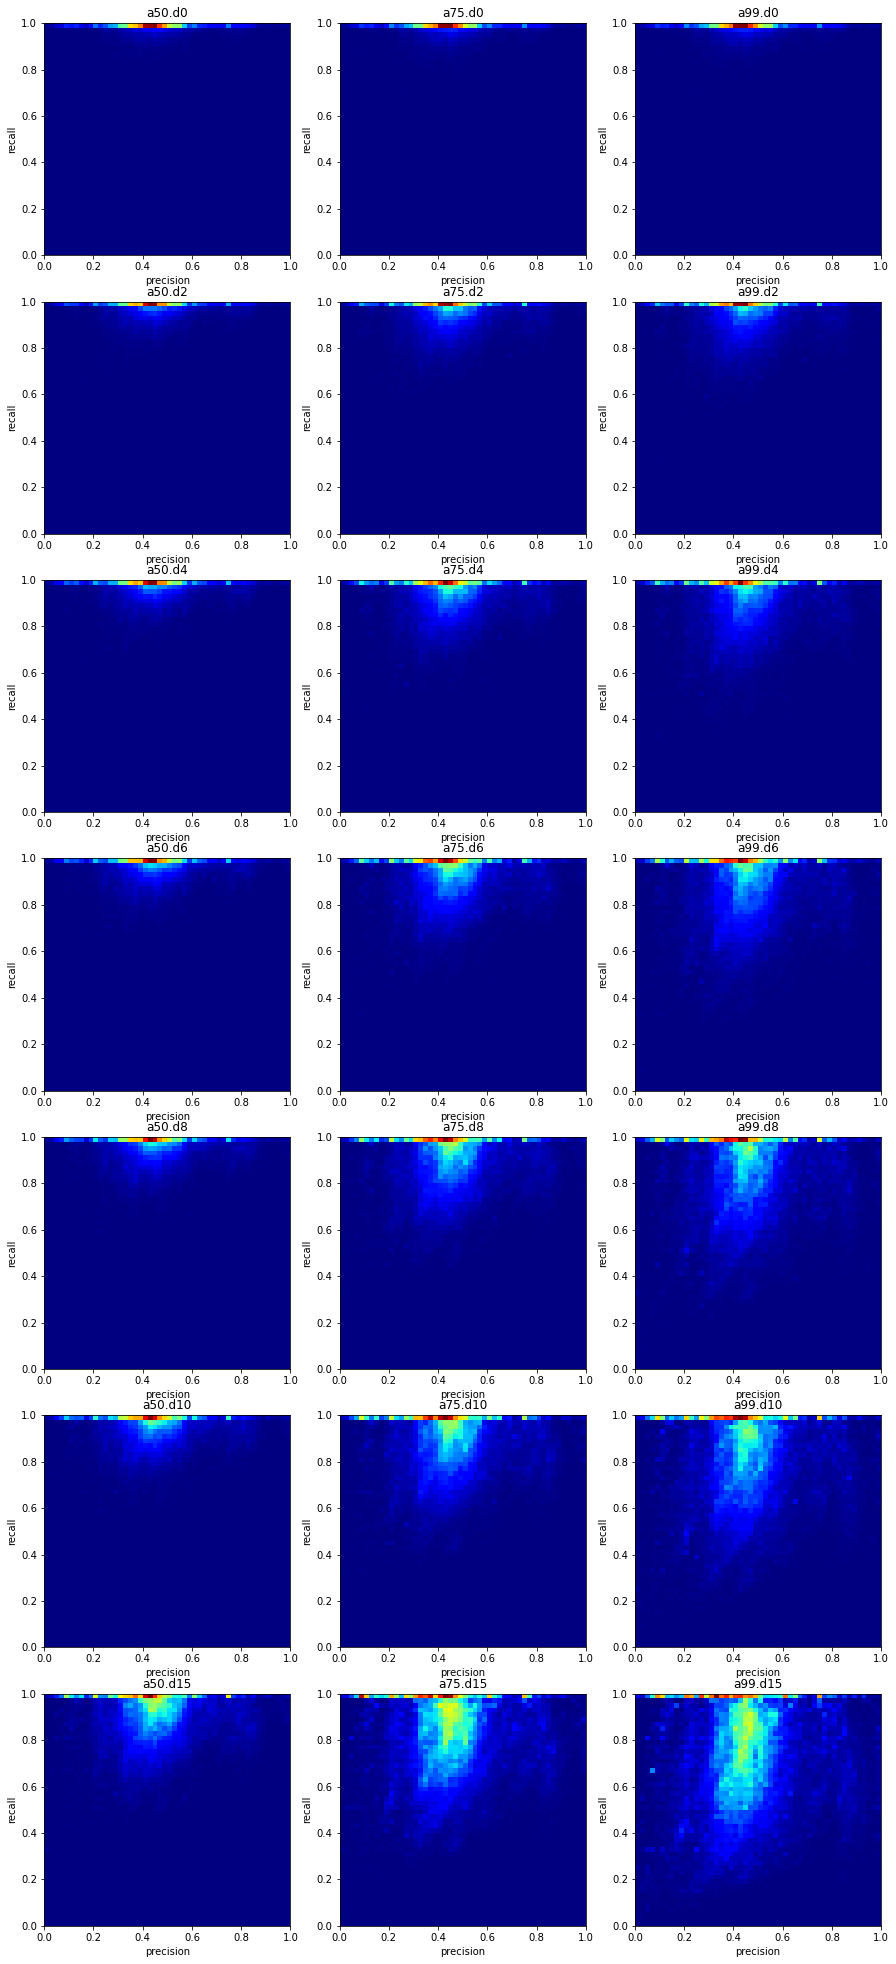

In [11]:
plot_precision_recall(groups, alphas, deltas)

Precision and recall heatmap, 0-40% sequence identities.

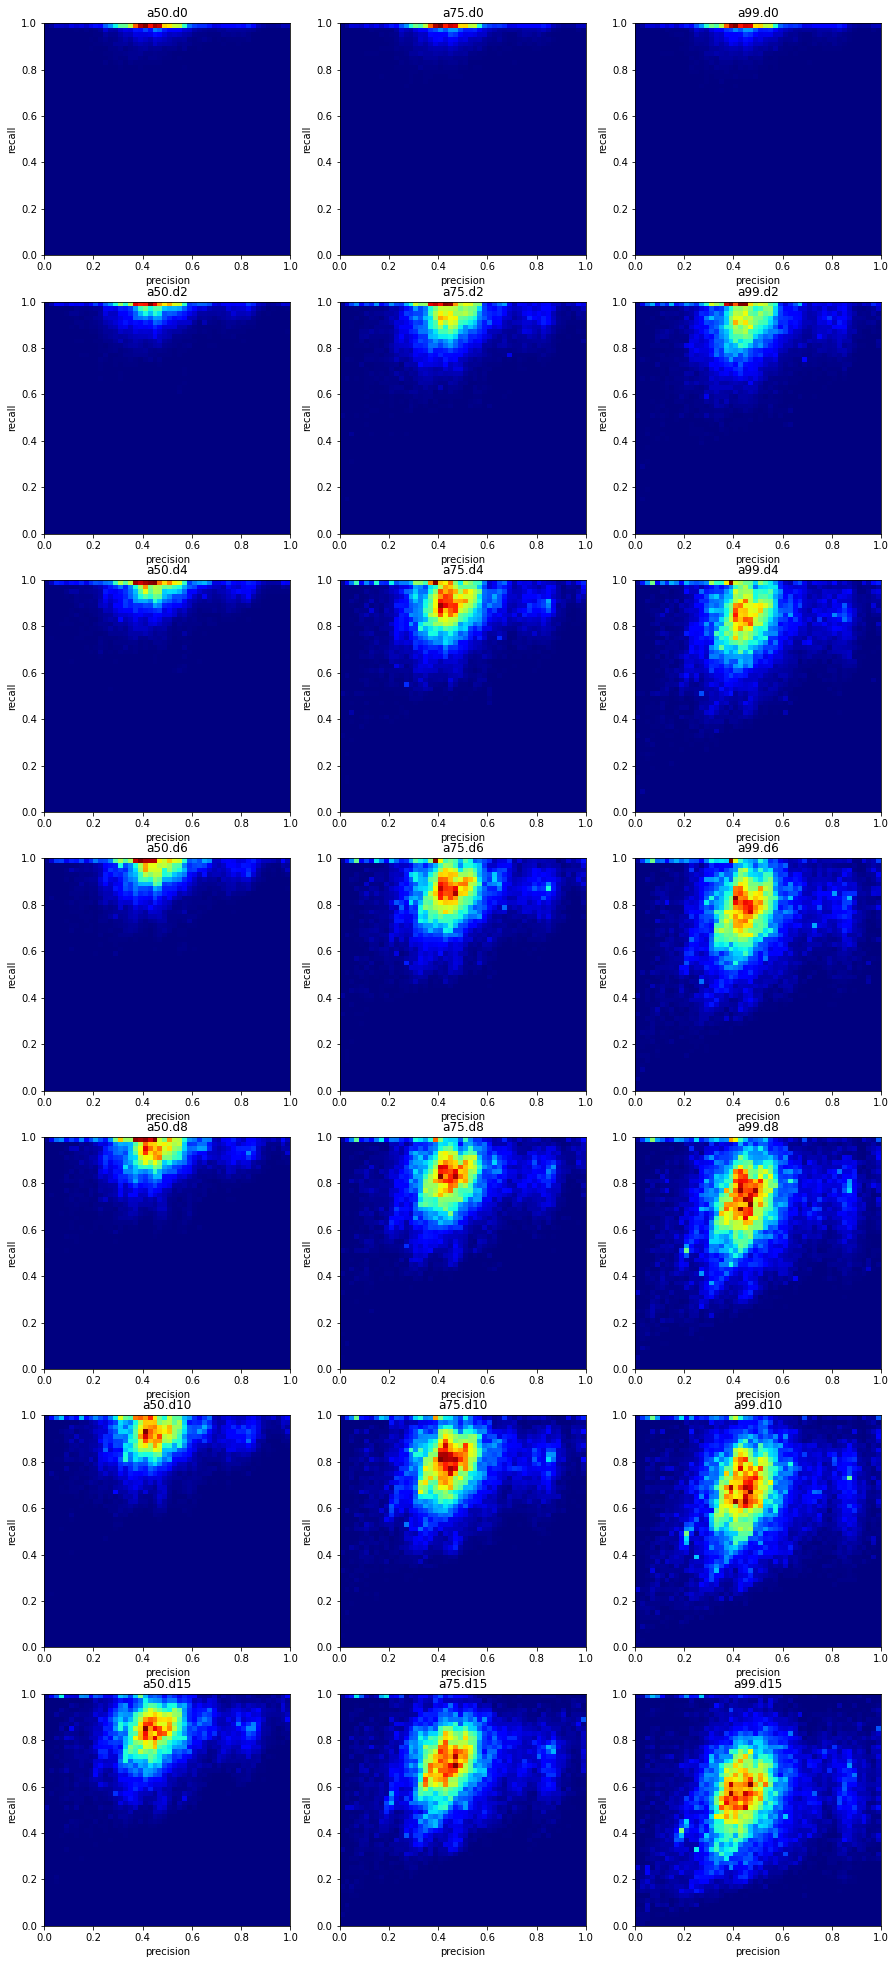

In [12]:
plot_precision_recall(groups, alphas, deltas, [0, 40])

Precision and recall heatmap, 40-70% sequence identities.

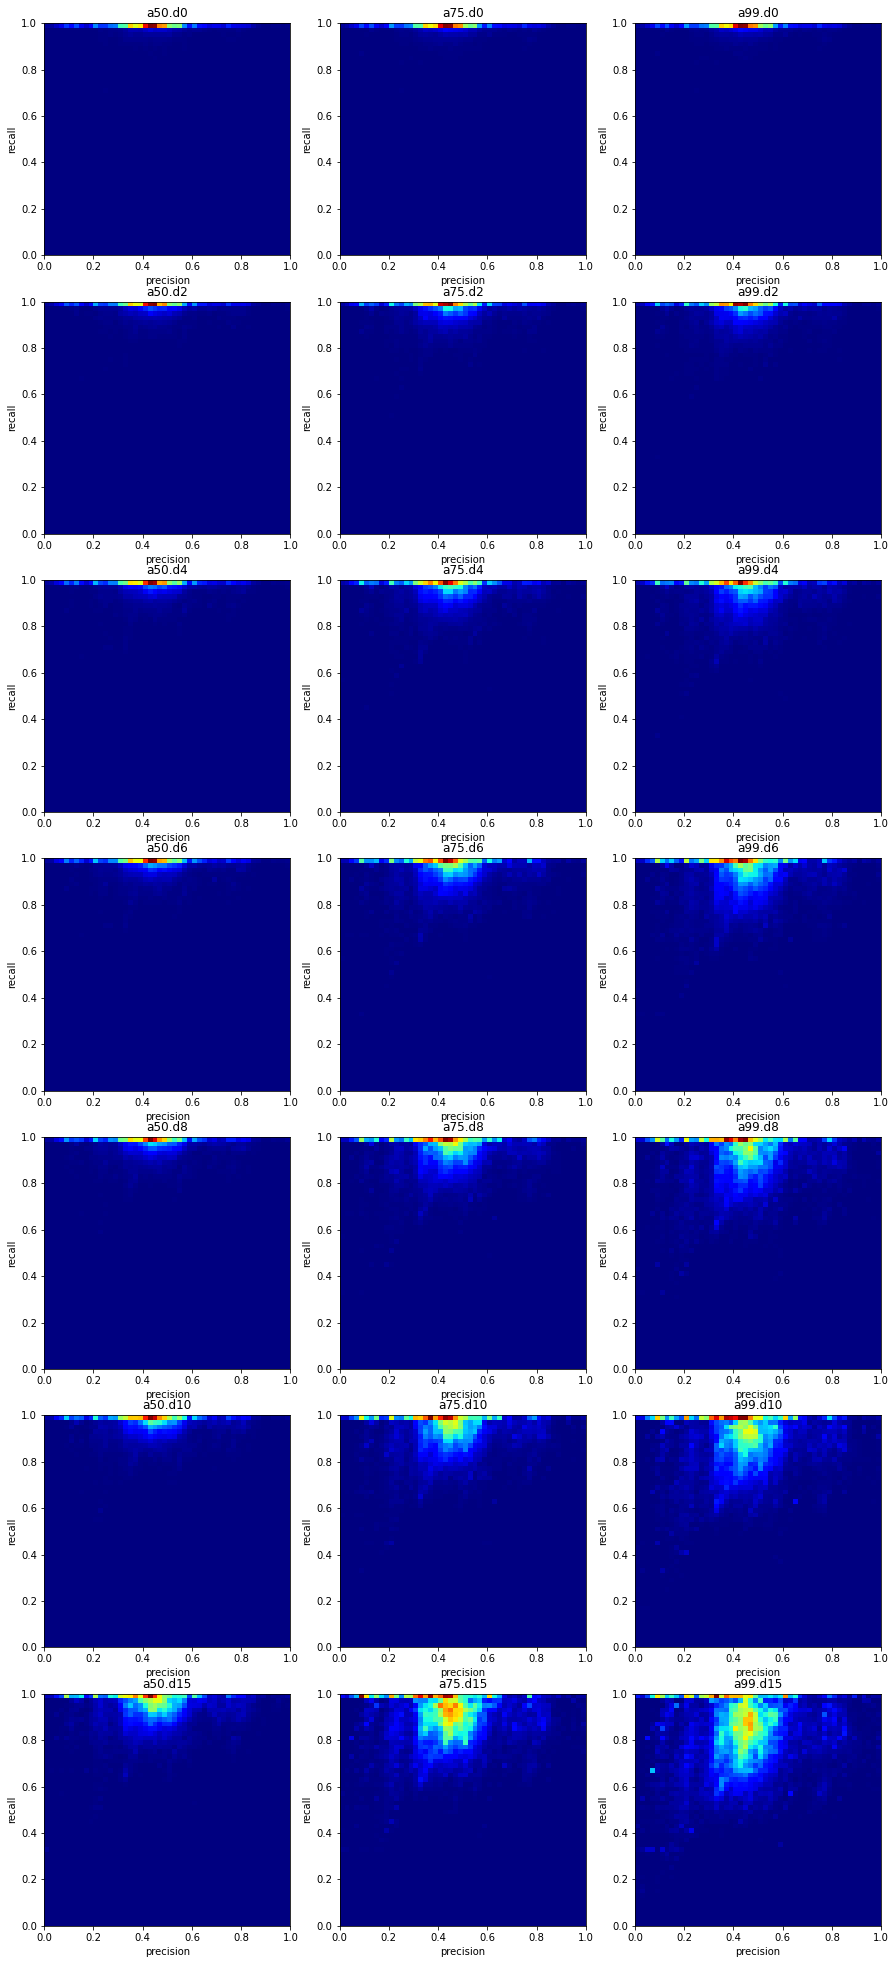

In [13]:
plot_precision_recall(groups, alphas, deltas, [40, 70])

Precision and recall heatmap, 70-100% sequence identities.

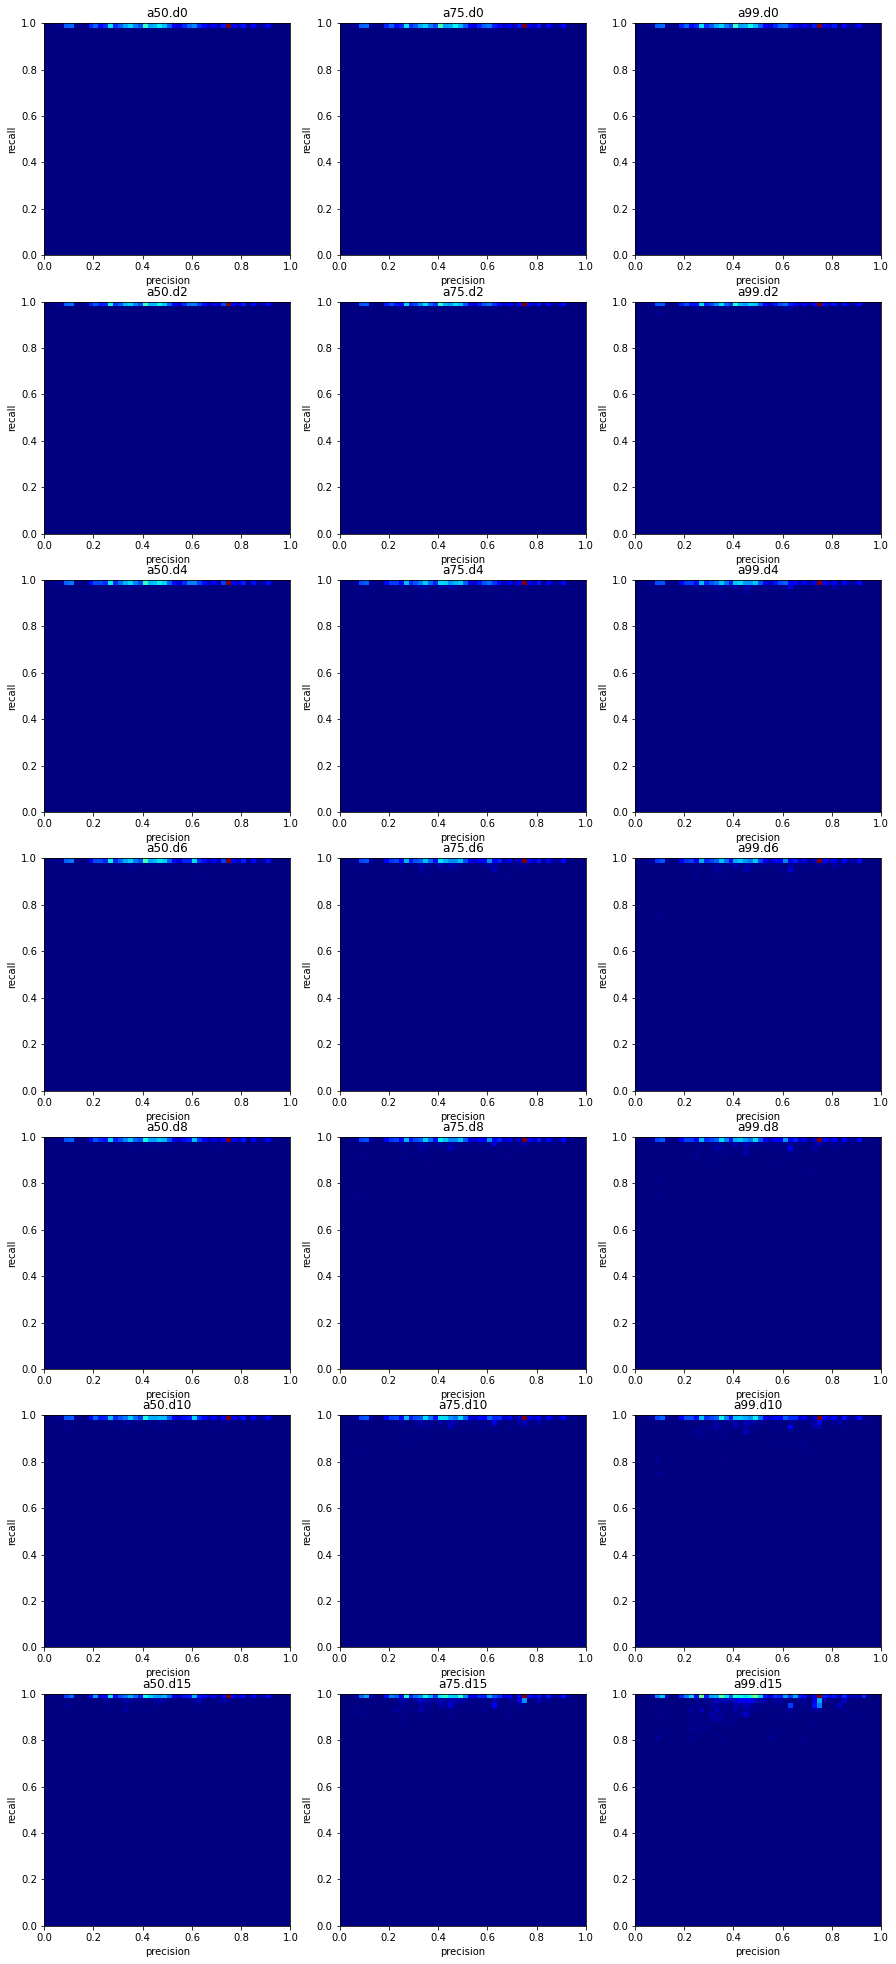

In [14]:
plot_precision_recall(groups, alphas, deltas, [70, 100])

F1-score vs. Safety Coverage (compression), all identities.

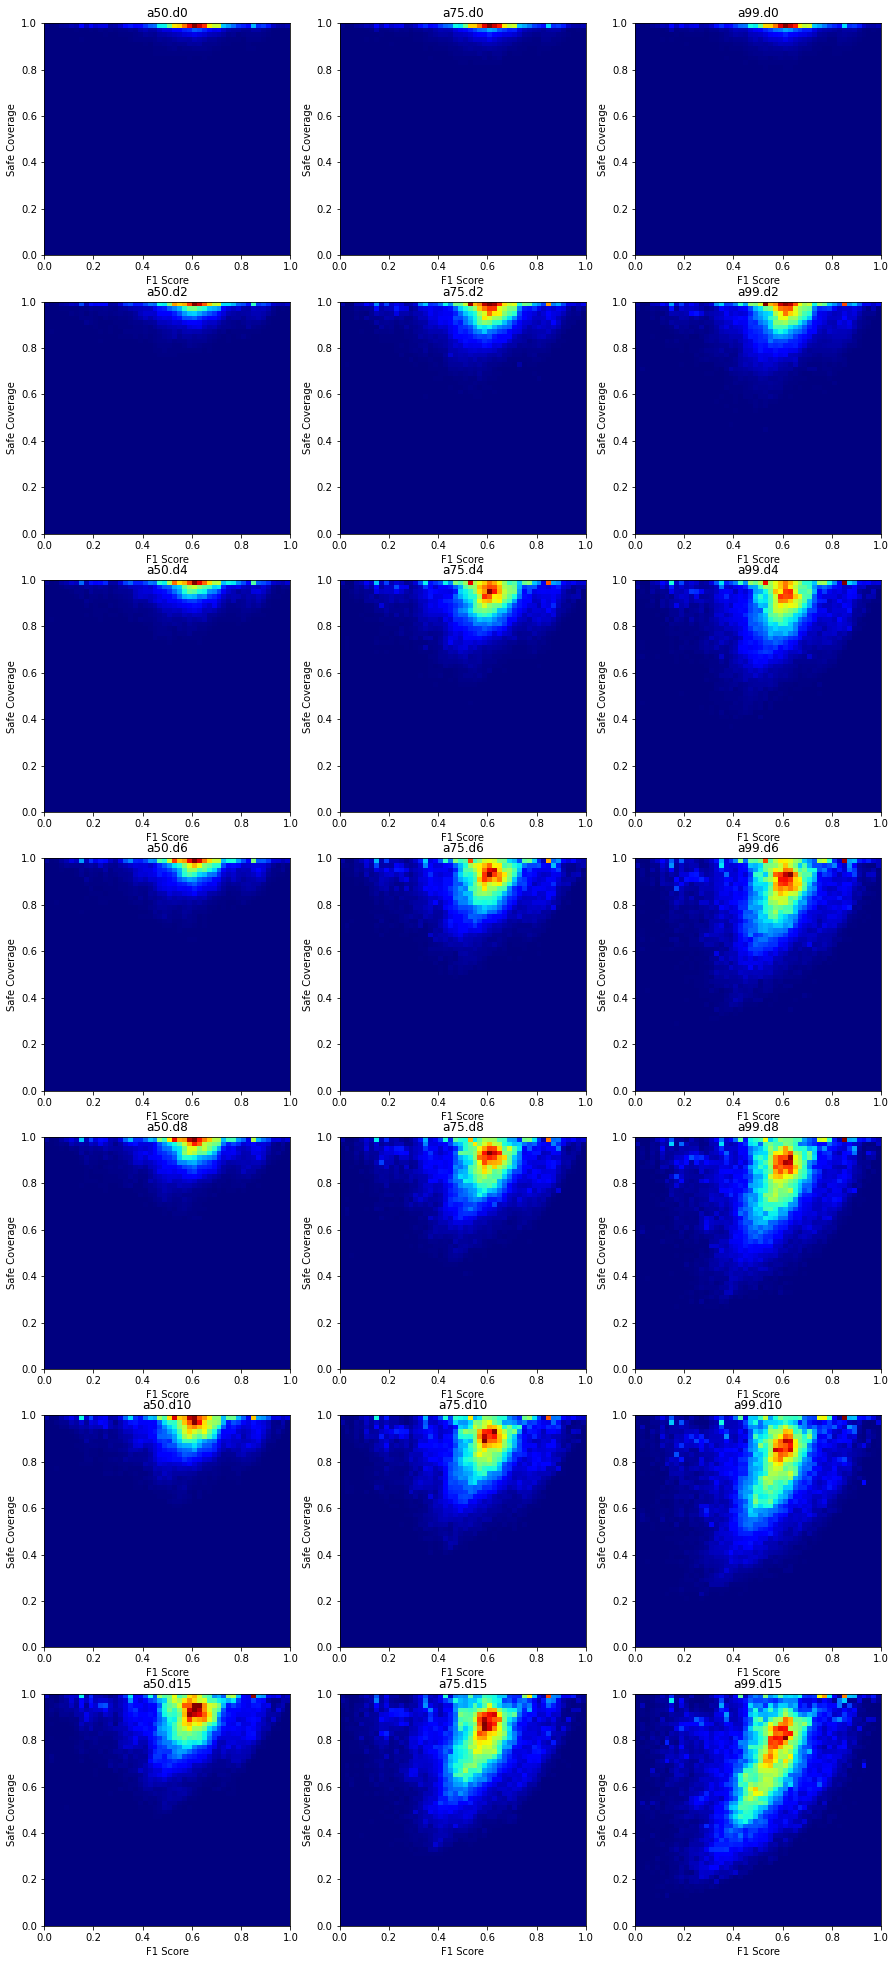

In [15]:
plot_f1(groups, alphas, deltas)

F1-score vs. Safety Coverage (compression), 0-40% identities.

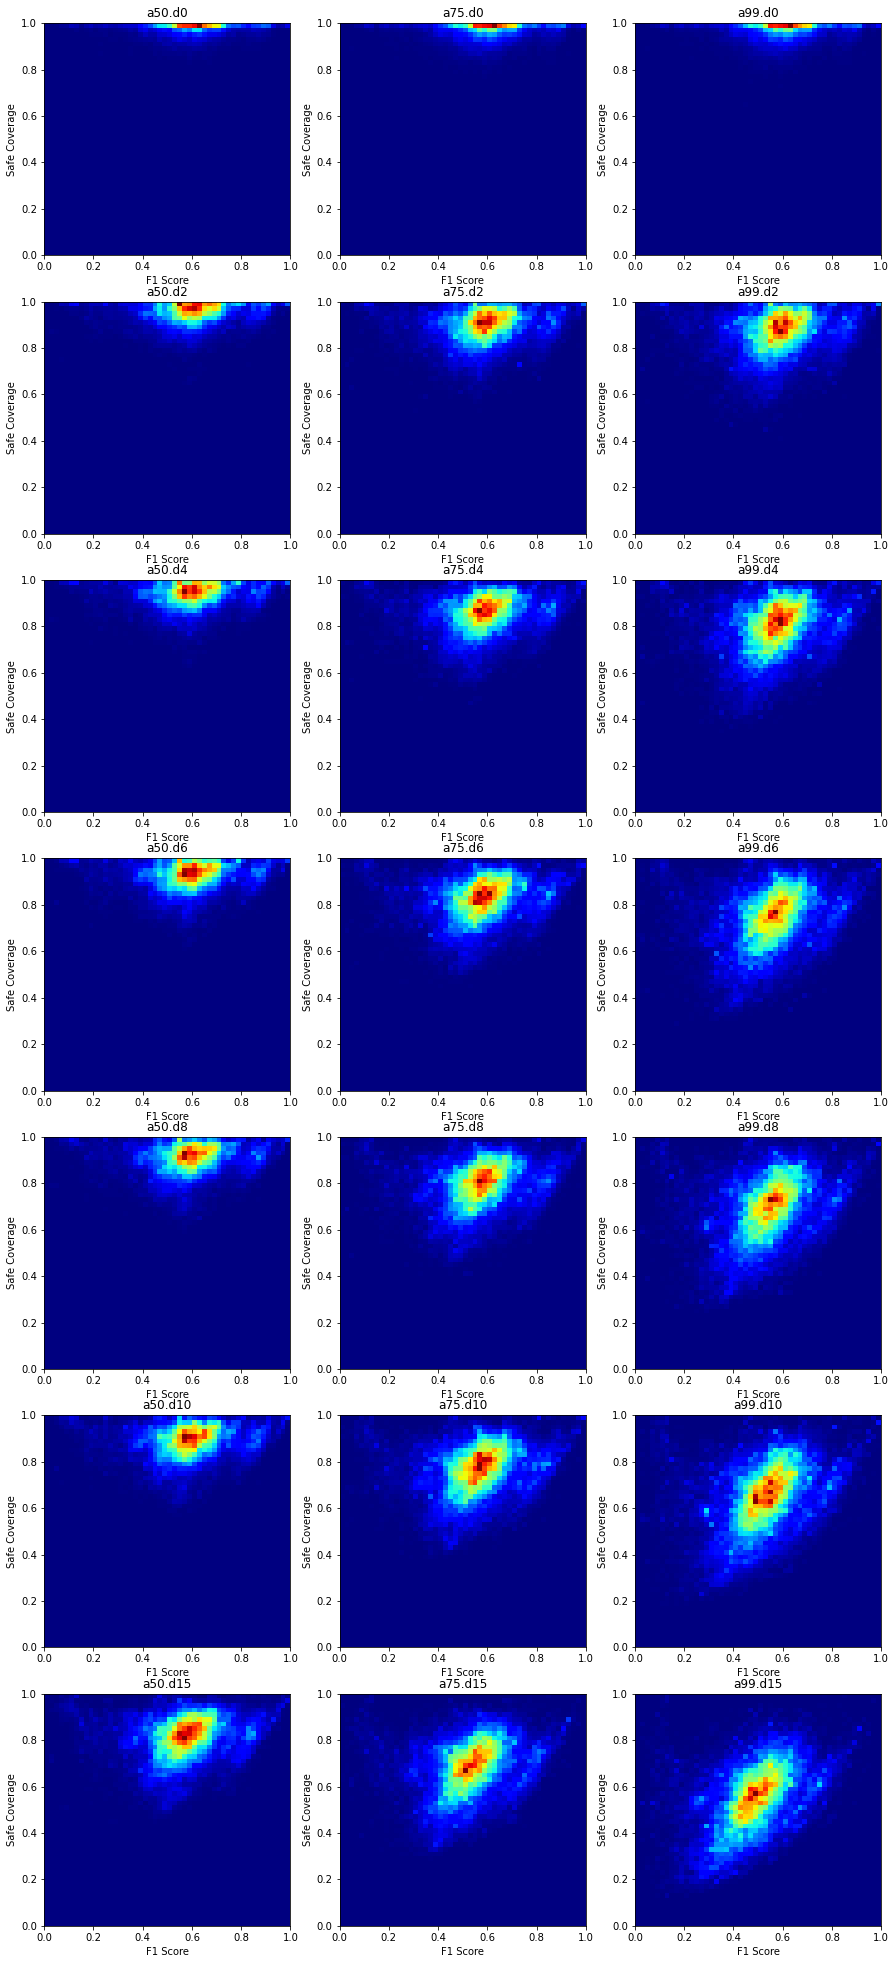

In [16]:
plot_f1(groups, alphas, deltas, [0, 40])

F1-score vs. Safety Coverage (compression), 40-70% identities.

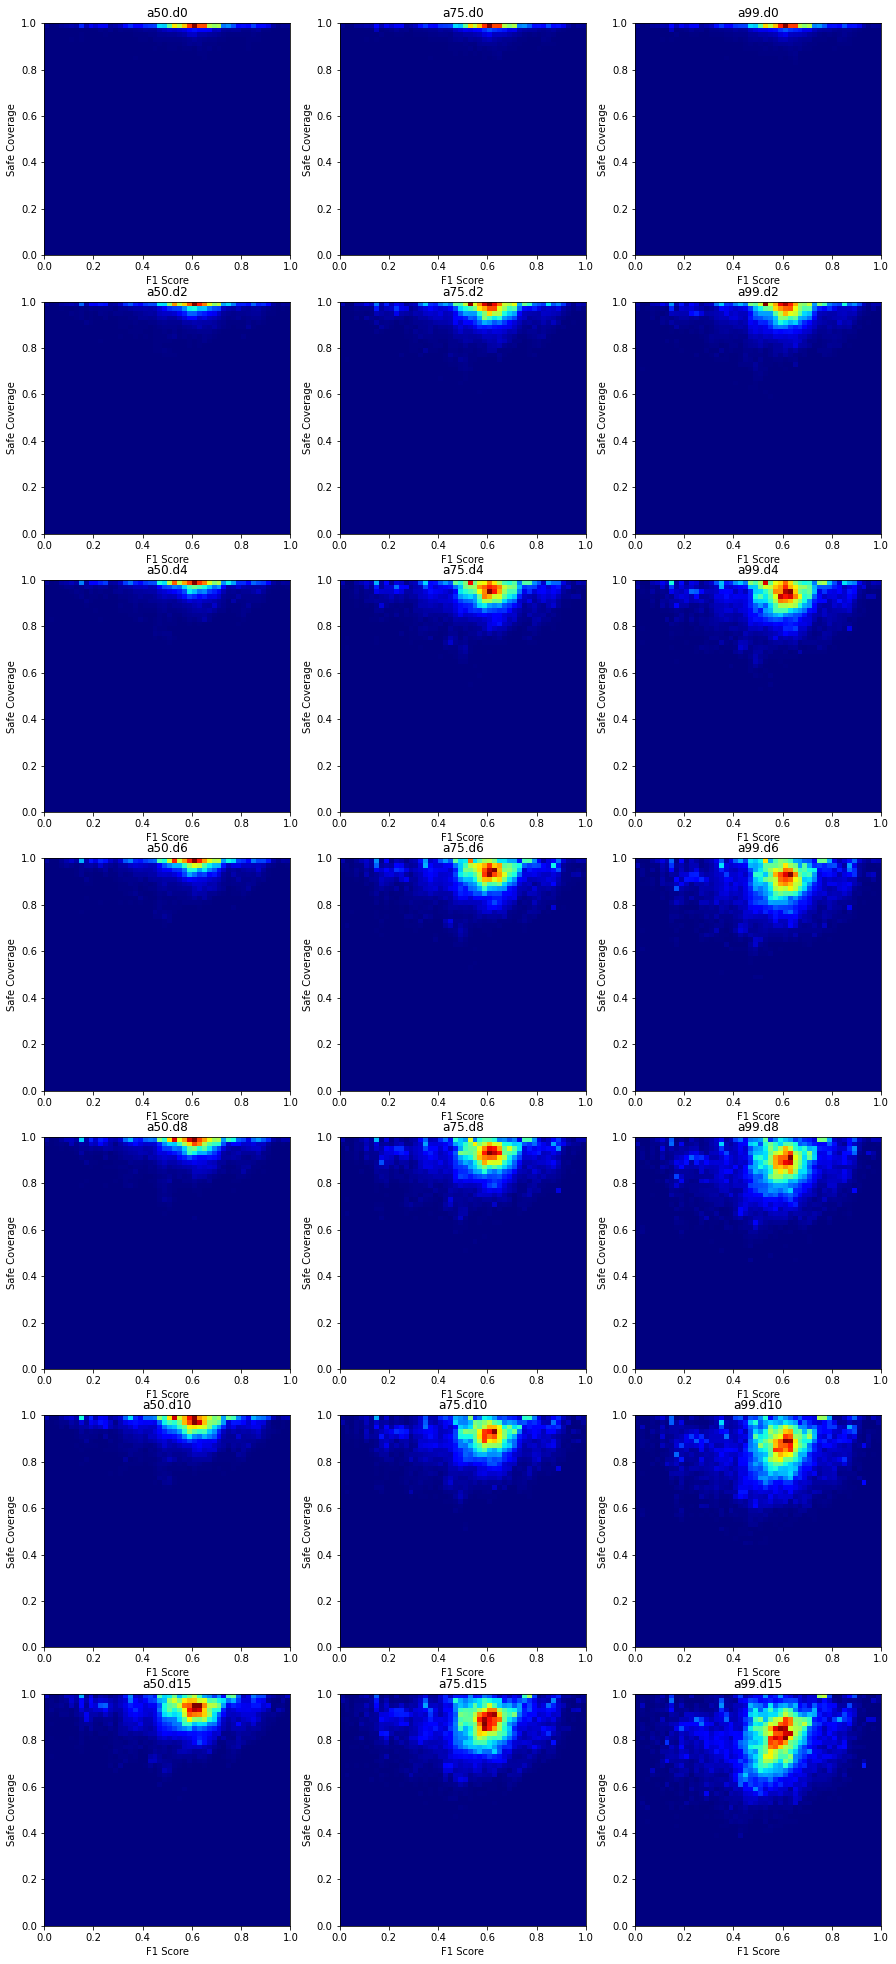

In [17]:
plot_f1(groups, alphas, deltas, [40, 70])

F1-score vs. Safety Coverage (compression), 70-100% identities.

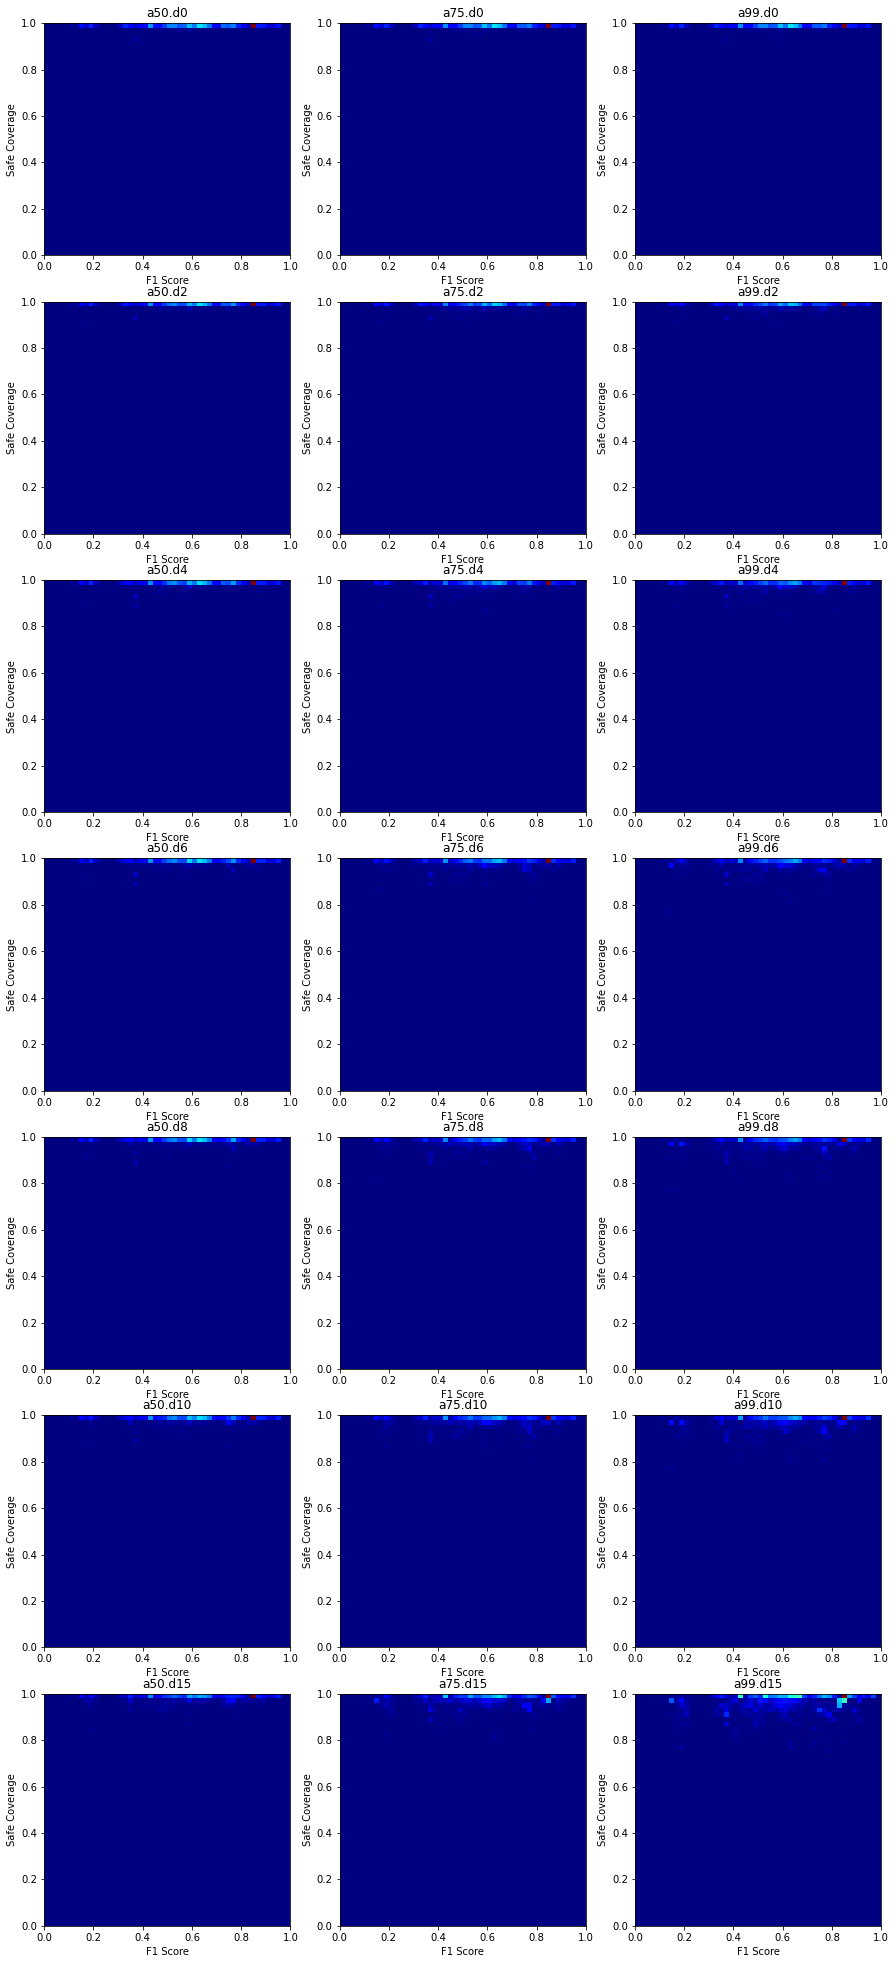

In [18]:
plot_f1(groups, alphas, deltas, [70, 100])

Boxplots, all identities.

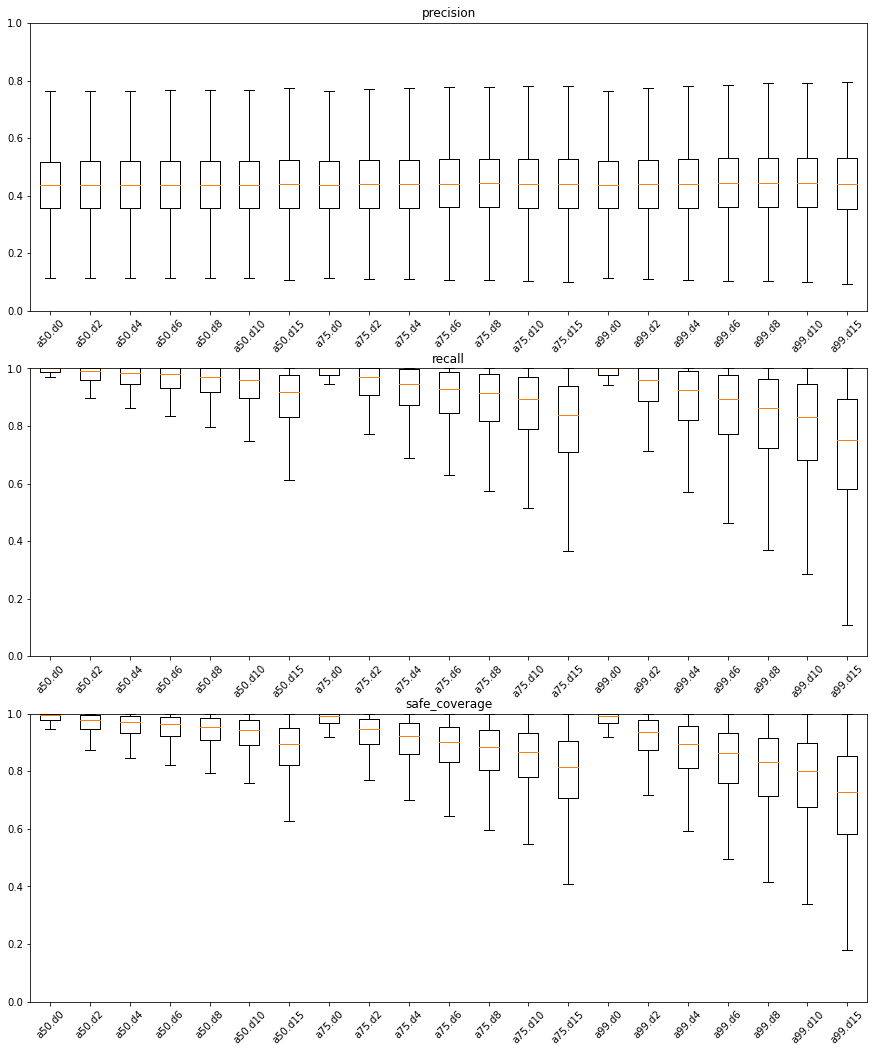

In [19]:
boxplot(groups, alphas, deltas, ["precision", "recall", "safe_coverage"])

Boxplots, 0-40% identities.

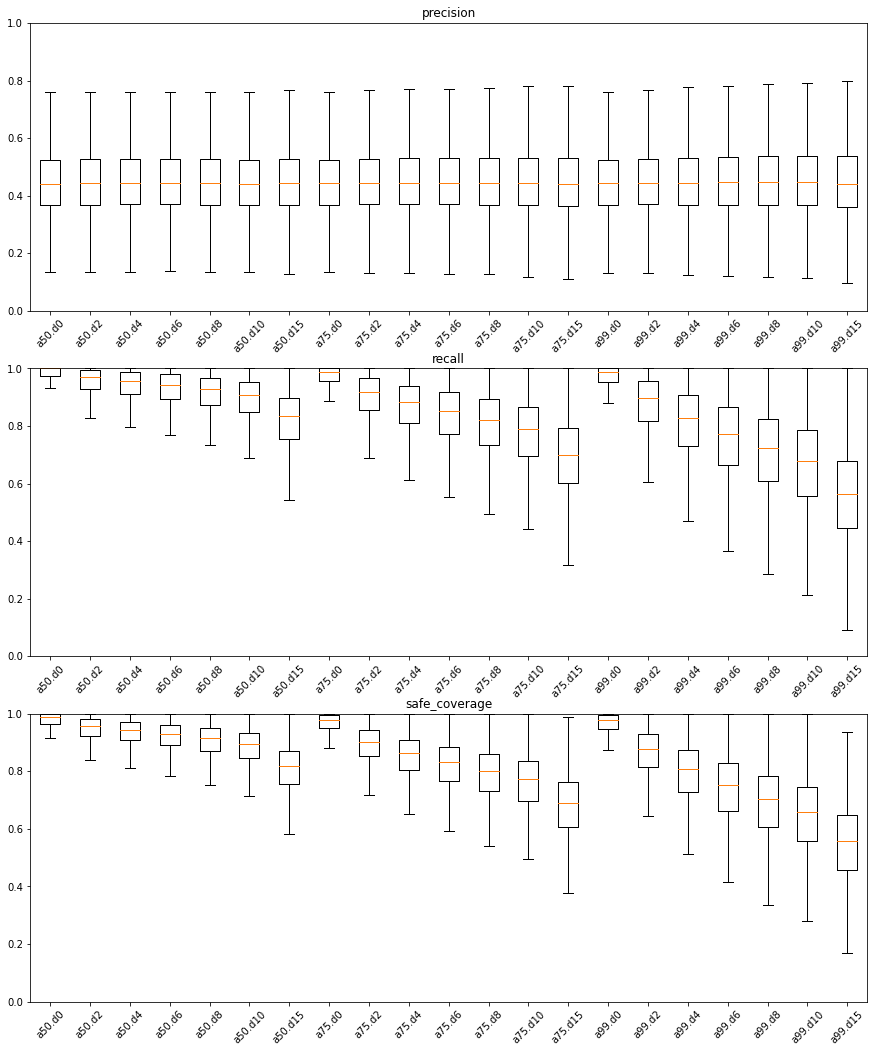

In [20]:
boxplot(groups, alphas, deltas, ["precision", "recall", "safe_coverage"], [0,40])

Boxplots, 40-70% identities.

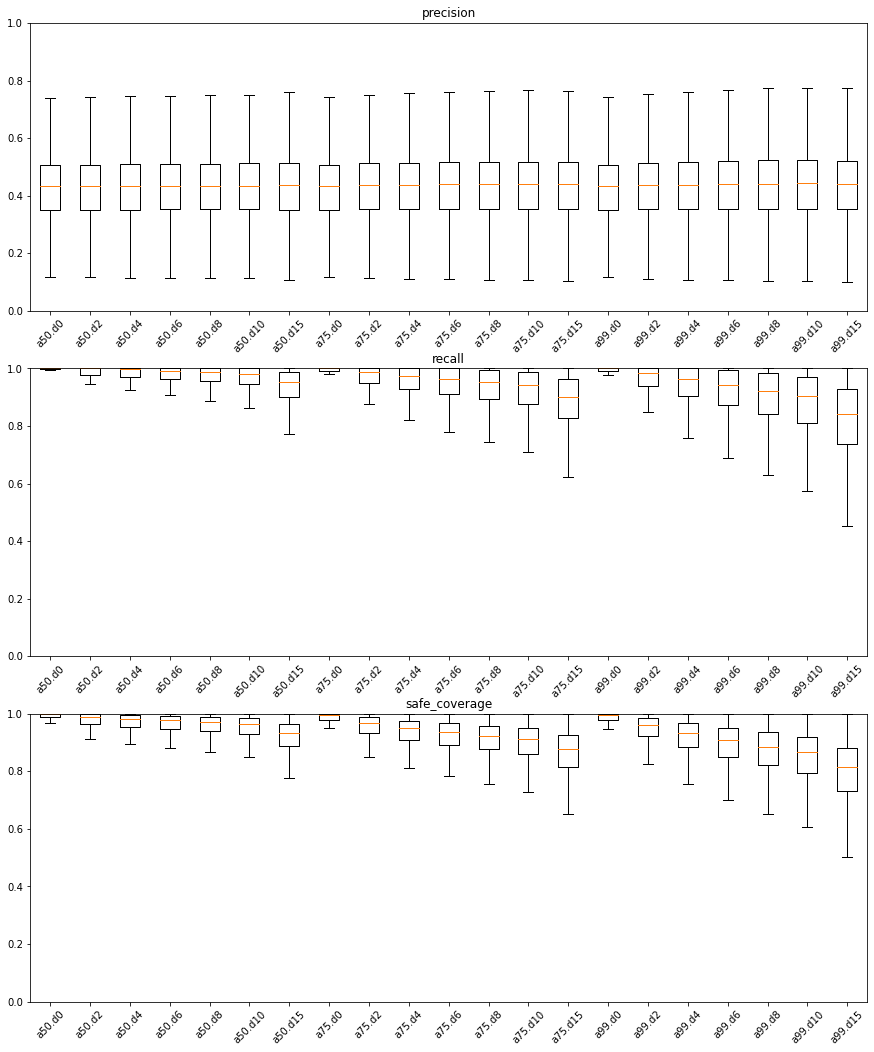

In [21]:
boxplot(groups, alphas, deltas, ["precision", "recall", "safe_coverage"], [40,70])

Boxplots, 70-100% identities.

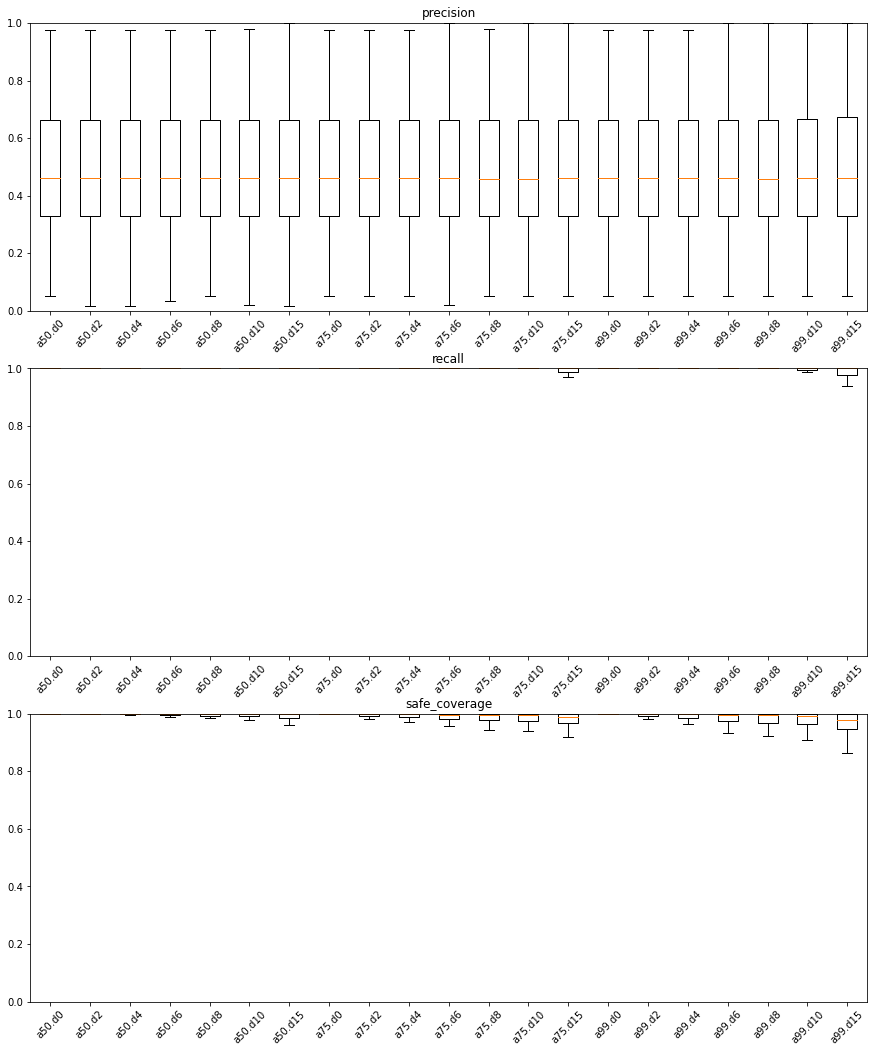

In [22]:
boxplot(groups, alphas, deltas, ["precision", "recall", "safe_coverage"], [70,100])

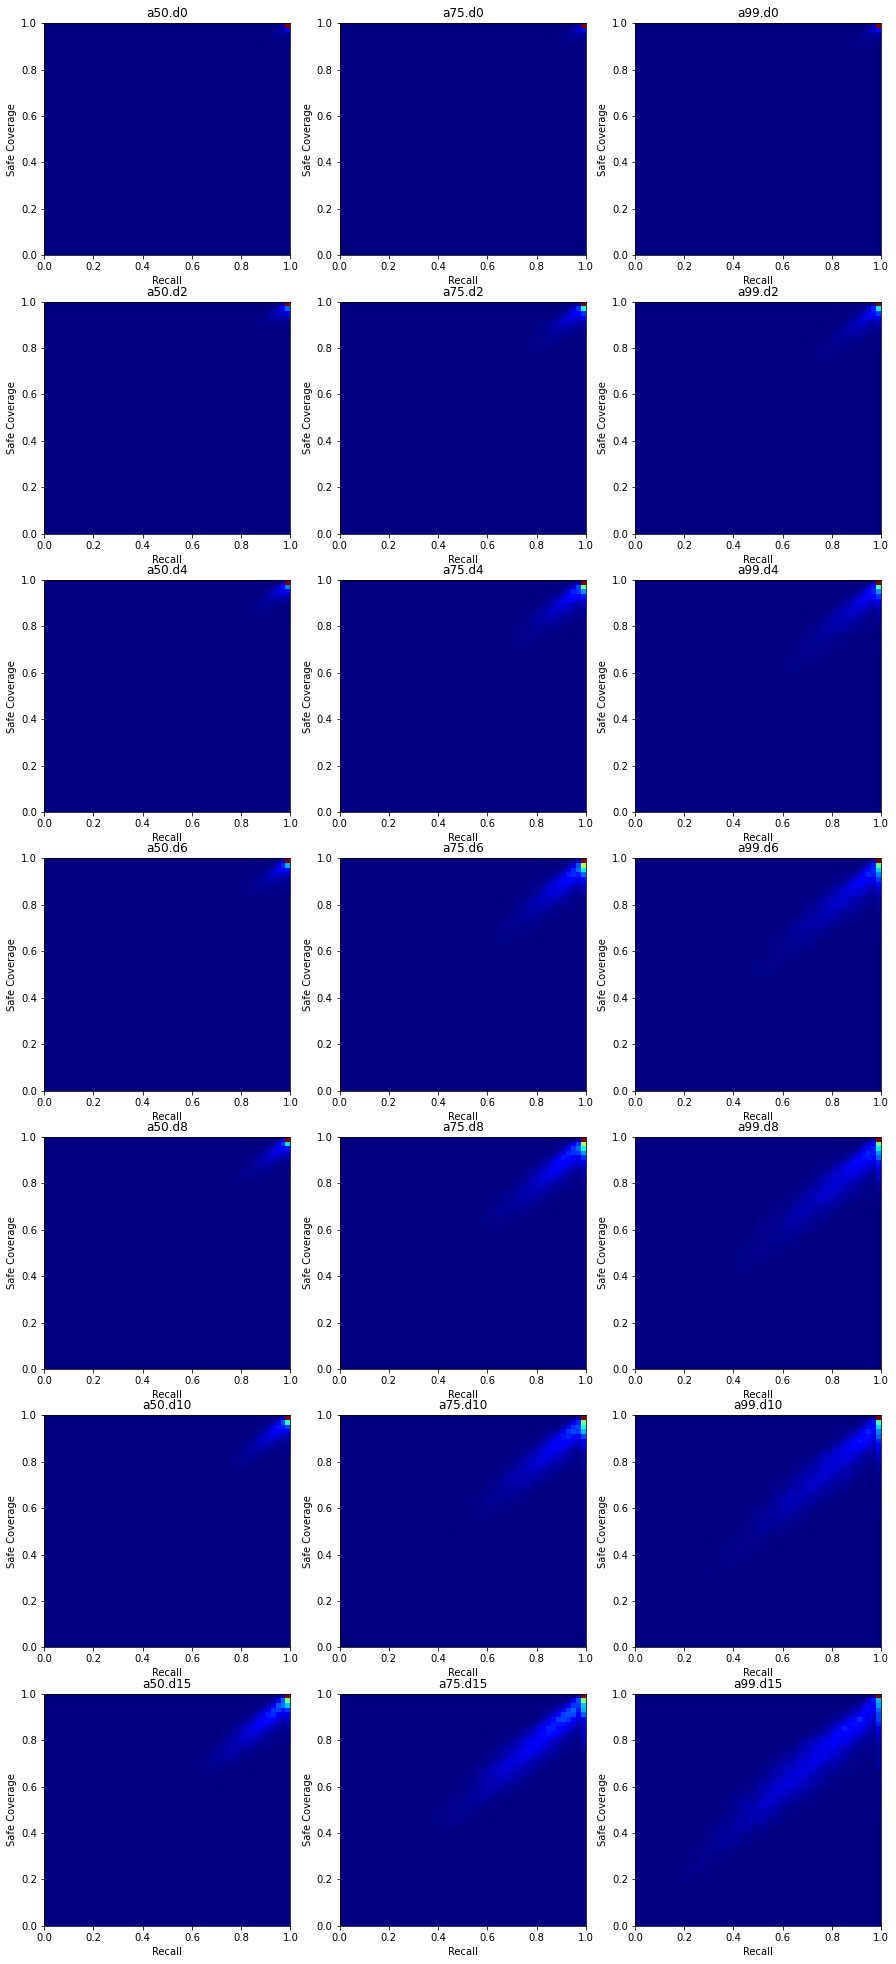

In [23]:
plot_recall_safe_coverage(groups, alphas, deltas)